In [1]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time


In [2]:
# Cell 2: Standard CNN Model
device = torch.device("cpu")

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 → 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 → 7x7
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [3]:
# Cell 3: Load Data
transform = transforms.ToTensor()
train_data = MNIST(root='./data', train=True, download=True, transform=transform)
test_data = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

# Add Gaussian Noise
def add_noise(tensor, std=0.5):
    return torch.clip(tensor + torch.randn_like(tensor) * std, 0., 1.)

noisy_test_images = add_noise(test_data.data.unsqueeze(1).float() / 255.)
noisy_test_loader = DataLoader(TensorDataset(noisy_test_images, test_data.targets), batch_size=1000)


In [4]:
# Cell 4: Training and Evaluation with Timing
def train(model, loader, optimizer, criterion, epochs=3):
    start_time = time.time()
    model.train()
    for ep in range(epochs):
        total, correct = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total += y.size(0)
            correct += (out.argmax(1) == y).sum().item()
        print(f"Epoch {ep+1}: Accuracy = {correct/total:.4f}")
    elapsed = time.time() - start_time
    print(f"Training time: {elapsed:.2f} seconds")
    return elapsed

def evaluate(model, loader):
    model.eval()
    correct = 0
    start_time = time.time()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
    elapsed = time.time() - start_time
    accuracy = correct / len(loader.dataset)
    return accuracy, elapsed


In [5]:
# Cell 5: Train Baseline Model
baseline = CNNModel().to(device)
optimizer = optim.Adam(baseline.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_time = train(baseline, train_loader, optimizer, criterion)


Epoch 1: Accuracy = 0.9457
Epoch 2: Accuracy = 0.9843
Epoch 3: Accuracy = 0.9889
Training time: 57.75 seconds


In [6]:
# Cell 6: Weight Sharing (Quantization)
def apply_weight_sharing(model, bits=4):
    """
    Apply uniform quantization to reduce unique weights.
    """
    n_clusters = 2 ** bits
    for name, param in model.named_parameters():
        if "weight" in name and len(param.shape) > 1:
            W = param.data
            W_min, W_max = W.min(), W.max()
            step = (W_max - W_min) / (n_clusters - 1)
            quantized = torch.round((W - W_min) / step) * step + W_min
            param.data = quantized
    return model


In [7]:
# Cell 7: Evaluate Baseline & Compressed Models
# Baseline evaluation
acc_clean, time_clean = evaluate(baseline, test_loader)
acc_noisy, time_noisy = evaluate(baseline, noisy_test_loader)

# Compressed evaluation
model_compressed = CNNModel().to(device)
model_compressed.load_state_dict(baseline.state_dict())
model_compressed = apply_weight_sharing(model_compressed, bits=4)

acc_clean_c, time_clean_c = evaluate(model_compressed, test_loader)
acc_noisy_c, time_noisy_c = evaluate(model_compressed, noisy_test_loader)


In [8]:
# Cell 8: Hashed Layers
class HashedLinear(nn.Module):
    def __init__(self, in_features, out_features, num_buckets=1000, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_buckets = num_buckets
        self.shared_weights = nn.Parameter(torch.randn(num_buckets) * 0.01)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.bias = None

        num_weights = in_features * out_features
        self.hash_indices = self._create_hash_indices(num_weights).view(out_features, in_features)

    def _create_hash_indices(self, num_weights):
        rng = torch.arange(num_weights)
        return torch.tensor([hash(int(i)) % self.num_buckets for i in rng])

    def forward(self, x):
        W = self.shared_weights[self.hash_indices]
        return F.linear(x, W, self.bias)


class HashedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_buckets=1000, stride=1, padding=0, bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.num_buckets = num_buckets
        self.stride = stride
        self.padding = padding
        self.shared_weights = nn.Parameter(torch.randn(num_buckets) * 0.01)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.bias = None

        num_weights = out_channels * in_channels * self.kernel_size[0] * self.kernel_size[1]
        self.hash_indices = self._create_hash_indices(num_weights).view(out_channels, in_channels, *self.kernel_size)

    def _create_hash_indices(self, num_weights):
        rng = torch.arange(num_weights)
        return torch.tensor([hash(int(i)) % self.num_buckets for i in rng])

    def forward(self, x):
        W = self.shared_weights[self.hash_indices]
        return F.conv2d(x, W, self.bias, stride=self.stride, padding=self.padding)


In [9]:
# Cell 9: Hashed CNN Model
class HashedCNN(nn.Module):
    def __init__(self, num_buckets=5000):
        super().__init__()
        self.conv1 = HashedConv2d(1, 32, 3, padding=1, num_buckets=num_buckets)
        self.conv2 = HashedConv2d(32, 64, 3, padding=1, num_buckets=num_buckets)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = HashedLinear(64*7*7, 128, num_buckets=num_buckets)
        self.fc2 = HashedLinear(128, 10, num_buckets=num_buckets)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [10]:
# Cell 10: Train & Evaluate Hashed CNN
hashed_model = HashedCNN(num_buckets=5000).to(device)
optimizer = optim.Adam(hashed_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_time_hashed = train(hashed_model, train_loader, optimizer, criterion)

acc_clean_h, time_clean_h = evaluate(hashed_model, test_loader)
acc_noisy_h, time_noisy_h = evaluate(hashed_model, noisy_test_loader)


Epoch 1: Accuracy = 0.8708
Epoch 2: Accuracy = 0.9420
Epoch 3: Accuracy = 0.9589
Training time: 57.45 seconds


In [11]:
# Cell 11: Final Comparison Table
df = pd.DataFrame({
    "Model": ["Baseline", "Compressed", "Hashed"],
    "Clean Accuracy (%)": [acc_clean * 100, acc_clean_c * 100, acc_clean_h * 100],
    "Noisy Accuracy (%)": [acc_noisy * 100, acc_noisy_c * 100, acc_noisy_h * 100],
    "Clean Inference Time (s)": [time_clean, time_clean_c, time_clean_h],
    "Noisy Inference Time (s)": [time_noisy, time_noisy_c, time_noisy_h],
    "Training Time (s)": [train_time, "-", train_time_hashed]
})
print(df)


        Model  Clean Accuracy (%)  Noisy Accuracy (%)  \
0    Baseline               98.83               70.12   
1  Compressed               98.87               73.22   
2      Hashed               96.93               53.39   

   Clean Inference Time (s)  Noisy Inference Time (s) Training Time (s)  
0                  1.029045                  0.817692         57.746602  
1                  1.009018                  0.733373                 -  
2                  1.000186                  0.733621         57.452889  


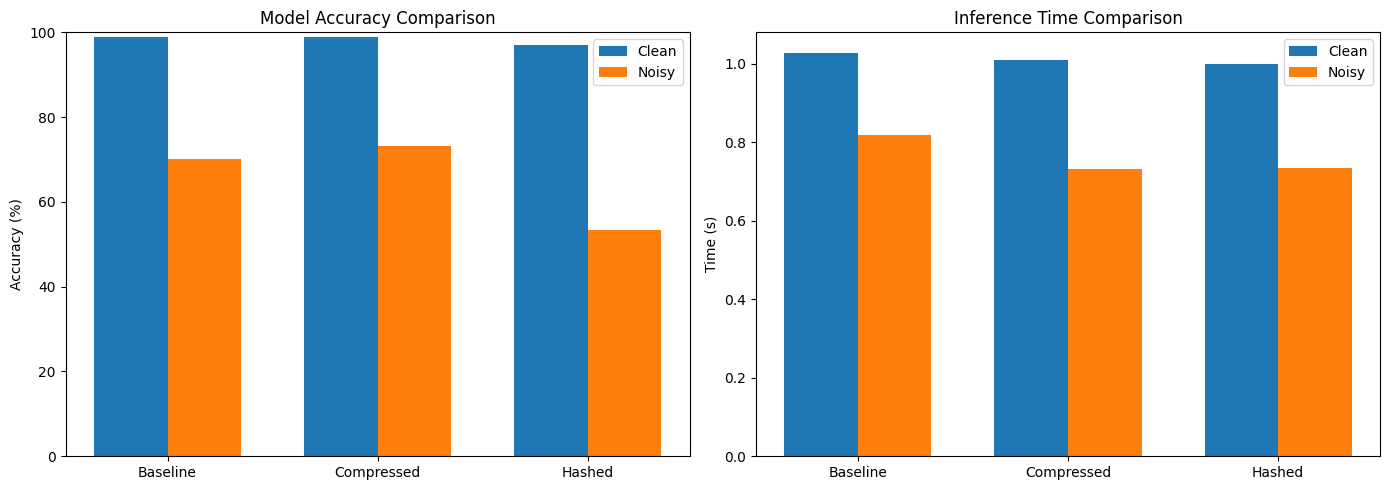

In [13]:
# Cell 12: Accuracy & Inference Time Plots
models = ["Baseline", "Compressed", "Hashed"]
x = np.arange(len(models))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Accuracy Plot ----
axes[0].bar(x - width/2, [acc_clean*100, acc_clean_c*100, acc_clean_h*100], width, label="Clean")
axes[0].bar(x + width/2, [acc_noisy*100, acc_noisy_c*100, acc_noisy_h*100], width, label="Noisy")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("Model Accuracy Comparison")
axes[0].set_ylim(0, 100)
axes[0].legend()

# ---- Inference Time Plot ----
axes[1].bar(x - width/2, [time_clean, time_clean_c, time_clean_h], width, label="Clean")
axes[1].bar(x + width/2, [time_noisy, time_noisy_c, time_noisy_h], width, label="Noisy")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylabel("Time (s)")
axes[1].set_title("Inference Time Comparison")
axes[1].legend()

plt.tight_layout()
plt.show()
